# Kickstarter Projects

## 目的
**プロジェクトのカテゴリや最終的に集めたい金額などからクラウドファンディングが成功するかどうかを予測する**

## Kaggle
https://www.kaggle.com/kemical/kickstarter-projects

# データセットの確認

## データの読み込み

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import datetime

In [3]:
# 分析用データとして ks-projects-201801.csv のみを用いる
data = pd.read_csv('./ks-projects-201801.csv' )

data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 各列の説明

参考) : <br>
https://kickstarternavi.jp/tips/196/<br>

https://help.kickstarter.com/hc/ja/articles/115005028514-Kickstarter-%E3%81%AE%E5%9F%BA%E6%9C%AC%E3%81%A8%E3%81%AF%E3%81%AA%E3%82%93%E3%81%A7%E3%81%99%E3%81%8B-

| 列名 | 説明 |
|:-|:-|
|　ID　|　識別番号　|
| name | クラウドファンディングのプロジェクト名 |
| category | カテゴリー |
| main_category | おおまかなカテゴリー |
| currency | 支援に必要な通貨 |
| deadline | クラウドファンディングの締め切り日 |
| goal | 集めたい金額 |
| launched | クラウドファンディングの開始日時 |
| pledged | 最終的に集まった支援金額 |
| state | 成功したかどうか　(今回の目的変数) |
| backers | 支援者の人数 |
| country | 募集側の国名 |
| usd pledged | 最終的に集まった支援金額(USドル, Kickstarterが掲載している金額) |
| usd_pledged_real | 最終的に集まった支援金額(USドル, Fixer.io APIによって計算した金額) |
| usd_goal_real | 集めたい金額(USドル) |

今回は成功するかどうかを予測するモデルを作りたいので，目的変数は **state** である．<br>
また予測はクラウドファンディングの募集開始前に行うので，
- pledged
- backers
- usd pledged
- usd_pledged_real

は説明変数として用いないものとする．

さらに
- IDはただの識別番号であり，予測に使用できるものではない点
- nameにも多くの情報は含まれているが，一つ一つが異なり扱いが非常に難しい点

からID, nameについても説明変数としては用いないものとする．

In [4]:
# dataから説明変数として用いない変数を消去
data.drop(['ID', 'name', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'], axis=1, inplace=True)

data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


## 各列の代表値と欠損値

In [5]:
# 量的変数の代表値を表示
data.describe()

,goal,usd_goal_real
count,3.786610e+05,3.786610e+05
mean,4.908079e+04,4.545440e+04
std,1.183391e+06,1.152950e+06
min,1.000000e-02,1.000000e-02
25%,2.000000e+03,2.000000e+03
50%,5.200000e+03,5.500000e+03
75%,1.600000e+04,1.550000e+04
max,1.000000e+08,1.663614e+08


In [6]:
# データ数の確認
data.shape

(378661, 9)

goalとusd_goal_realの最小値が1ドルを切っている． $\rightarrow$ 異常値の可能性があるので要確認<br>
goalの平均額が第三四分位数よりも大きくなっている． $\rightarrow$ goalの分布は高額なものがかなり少ないと予想

In [7]:
# dataの欠損値確認
data.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

上記から今回用いるデータには欠損値がないことがわかるので，欠損値の補完は行わない．

# 変数の分布の可視化

## 目的変数の分布の可視化

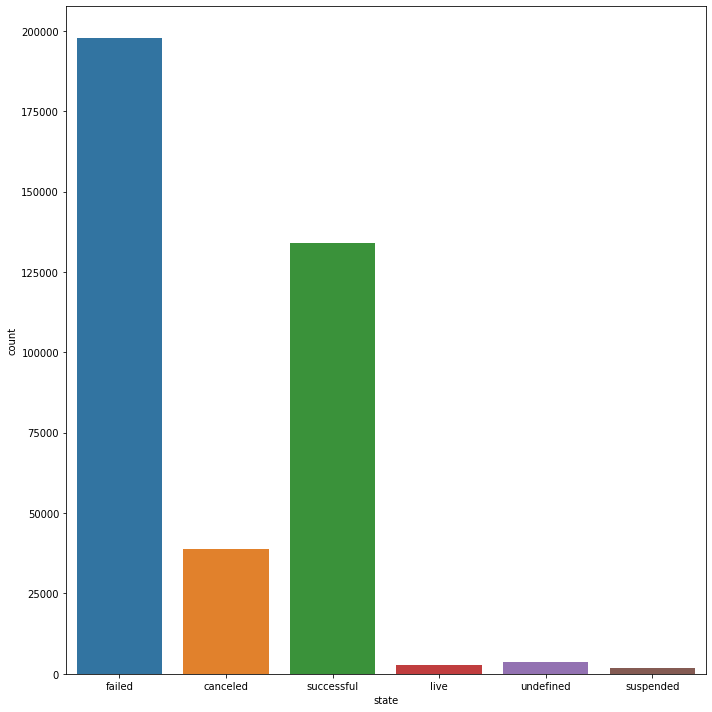

In [8]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

In [9]:
data['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [10]:
data_successful = data['state']=='successful'
print(f'クラウドファンディングの成功率 : {data_successful.sum() / data.shape[0]}')

クラウドファンディングの成功率 : 0.3537623362321443


In [11]:
data_live = data['state']=='live'
print(f'liveの割合 : {data_live.sum() / data.shape[0]}')
print(f'liveのデータ数 : {data_live.sum()}')

liveの割合 : 0.0073918359693763026
liveのデータ数 : 2799


In [12]:
data_failed = data['state']=='failed'
print(f'successful + failed : {(data_successful.sum() + data_failed.sum()) / data.shape[0]}')

successful + failed : 0.8759153966212523


クラウドファンディングの成功率は35.38%と，半分以上は成功していないことがわかる．<br>
successfulとfailedが全体の87.59%を占めていることがわかる．<br>
また，全体の0.74%を占めるliveはまだクラウドファンディングを行っているデータであることもわかる．<br>
今回はクラウドファンディングが成功するかどうかを予測したいので，liveは分析のデータから除外し，successful以外の4つのカテゴリについてはfailedとしてまとめて分析を行うものとする．

In [13]:
# 最後にliveの予測を行うため，stateがliveのデータをdata_live_onlyとして保持
data_live_only = data[data['state']=='live']
# live以外のデータ
data = data[data['state']!='live']
data = data.reset_index(drop=True)
data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


In [14]:
# dataのsuccessful以外のカテゴリをfailedに変更
data = data.replace({'canceled' : 'failed', 'undefined' : 'failed', 'suspended' : 'failed'})
data['state'].unique()

array(['failed', 'successful'], dtype=object)

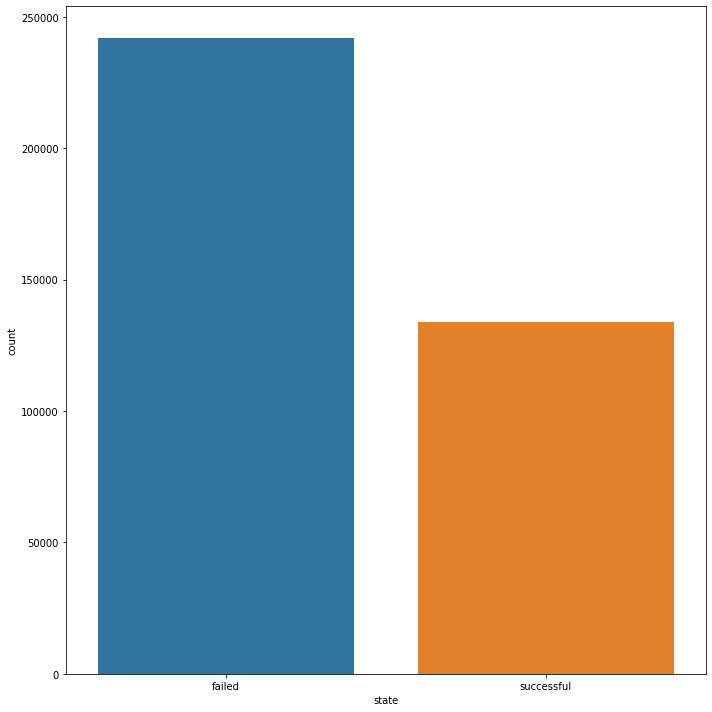

In [15]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

## 説明変数の分布の可視化

### category

In [16]:
data['category'].value_counts()

Product Design     22077
Documentary        16082
Music              15647
Tabletop Games     14072
Shorts             12311
                   ...  
Residencies           69
Letterpress           48
Chiptune              35
Literary Spaces       23
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [17]:
print(set(data['category']))

{"Children's Books", 'Quilts', 'Jazz', 'Pottery', 'Jewelry', 'Performances', 'Hip-Hop', 'Apparel', 'Hardware', 'Fabrication Tools', 'Thrillers', 'Spaces', 'Web', 'Mobile Games', 'Product Design', 'Comic Books', 'Footwear', 'Painting', 'Gaming Hardware', 'Comics', 'Video', 'Events', 'Pop', 'Childrenswear', 'Farms', 'Translations', 'Wearables', 'Indie Rock', 'Audio', 'Print', 'Periodicals', 'Graphic Design', 'Mixed Media', 'Community Gardens', 'Textiles', 'Software', 'Makerspaces', 'Design', 'Residencies', 'Fashion', 'Food Trucks', 'Ready-to-wear', 'Ceramics', 'Journalism', 'Knitting', 'Weaving', 'Fine Art', 'Country & Folk', 'Conceptual Art', 'Academic', 'World Music', 'Graphic Novels', 'Bacon', 'Science Fiction', 'Printing', 'Crochet', 'DIY Electronics', 'Metal', 'Comedy', 'Webcomics', 'Video Games', 'Tabletop Games', 'Robots', 'Couture', 'Punk', 'Animals', 'Narrative Film', 'Film & Video', 'Interactive Design', 'Chiptune', 'Digital Art', 'Architecture', 'Art', 'Embroidery', 'Performan

In [18]:
print(sum(data['category']=='other'))

0


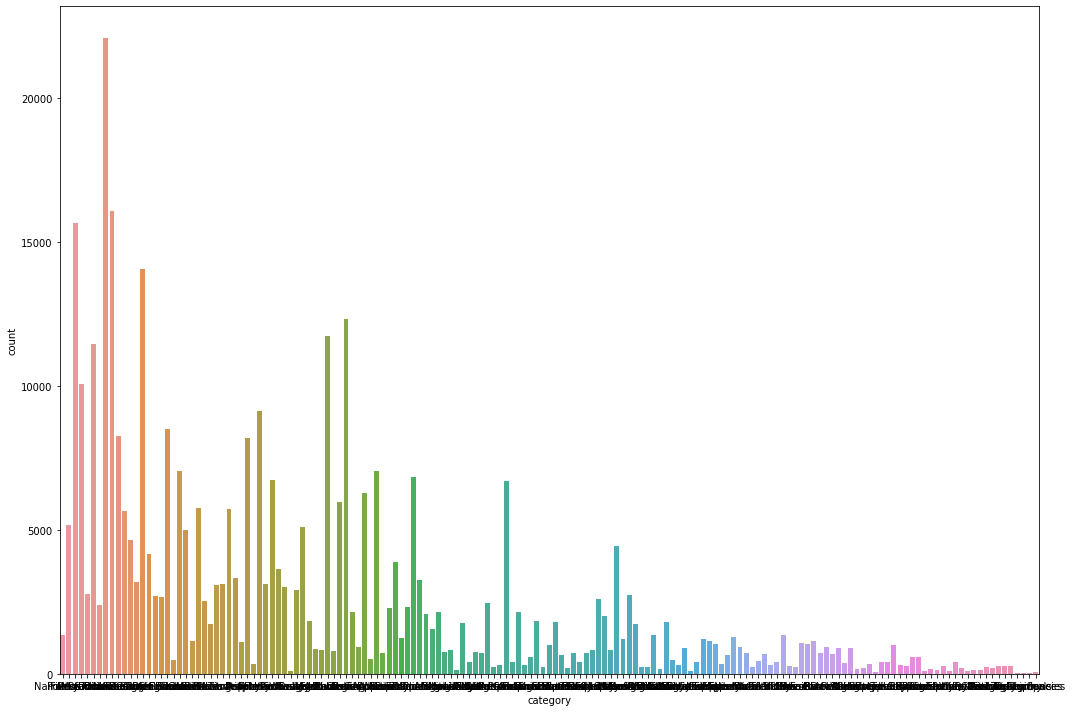

In [19]:
plt.figure(figsize=(15,10))
sns.countplot(x='category', data=data)
plt.tight_layout()

In [20]:
data_category = data['category'].value_counts()
data_category = pd.DataFrame(data_category)

print('categoryの出現回数が3000回以上のカテゴリ数')
print(sum(data_category['category'] >= 3000))
print('categoryの出現回数が3000回以上のデータ数')
print(data_category[data_category['category'] >= 3000].sum()[0] / data.shape[0])

categoryの出現回数が3000回以上のカテゴリ数
37
categoryの出現回数が3000回以上のデータ数
0.7168109572130197


categoryはmian_categoryをより詳しく分類したもので，159種類ある．<br>
このまま用いるとカテゴリ数が多く，各カテゴリの出現回数にはばらつきがあるため，出現頻度の少ないカテゴリをまとめてしまいたい．<br>
そこで出現回数が3000回以上のカテゴリはそのまま用いて，3000回以下のカテゴリをまとめることを考える．<br>
出現回数が3000回以下のカテゴリとしたのは，出現回数が3000回というのは出現頻度が全体の1%以下だからである．<br>
この場合全体の28.32%がその他に分類されることになり，カテゴリ数を1/4程度に減らすことができる．

In [21]:
# 出現回数が3000回以下のデータを収集
data_cat_3000 = data['category'].value_counts()<=3000
data_cat_3000 = pd.DataFrame(data_cat_3000)
data_cat_3000 = data_cat_3000[data_cat_3000['category']==True]
data_cat_3000

,category
Gadgets,True
Restaurants,True
Mixed Media,True
Comic Books,True
Art Books,True
...,...
Residencies,True
Letterpress,True
Chiptune,True
Literary Spaces,True


In [22]:
# 出現回数が3000回以下のカテゴリを'Other'に変換
for j in range(len(data)):
    for i in range(len(data_cat_3000)):
        if data_cat_3000.index[i] == data['category'][j]:
            data['category'][j] = 'Other'
data.head()

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00


In [23]:
# 出現回数3000回以上の37のカテゴリと'Other'を合わせてカテゴリの数が38になっているかの確認
len(data['category'].unique())

38

### main_category

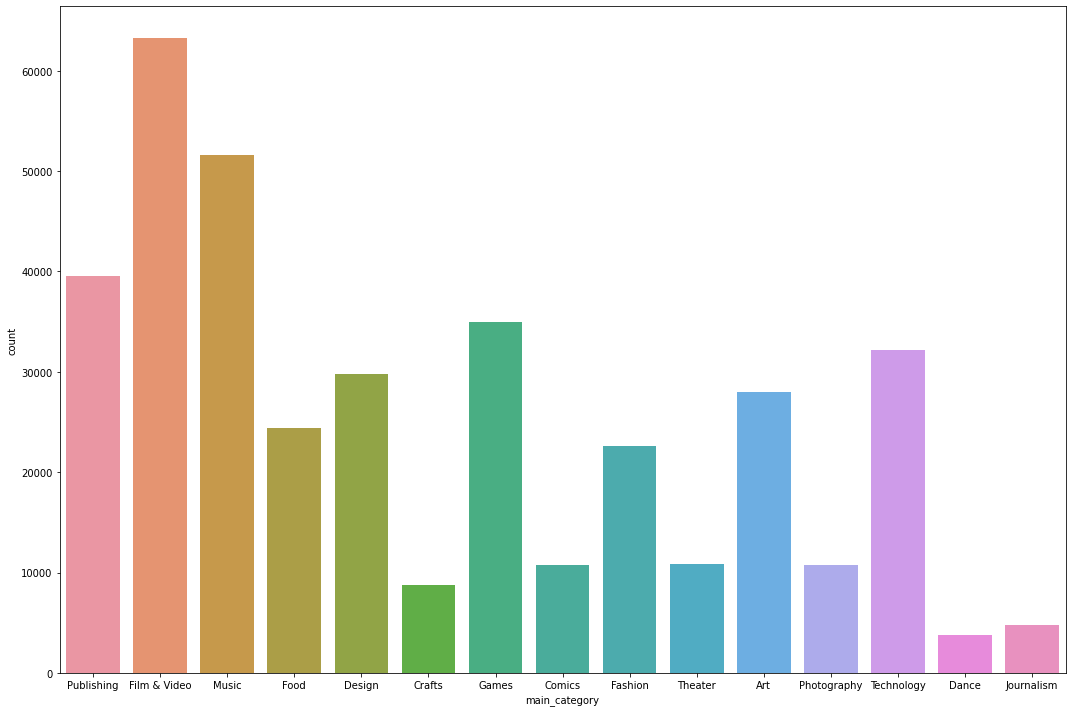

In [24]:
plt.figure(figsize=(15,10))
sns.countplot(x='main_category', data=data)
plt.tight_layout()

In [25]:
data['main_category'].value_counts()

Film & Video    63253
Music           51637
Publishing      39575
Games           34944
Technology      32192
Design          29765
Art             27959
Food            24418
Fashion         22566
Theater         10872
Comics          10743
Photography     10731
Crafts           8733
Journalism       4724
Dance            3750
Name: main_category, dtype: int64

main_categoryは15種類存在する．<br>
カテゴリごとの数にばらつきはあるが，どのカテゴリも一定程度のデータ数を有しているのでmain_category変数はこのまま使用する．

### currency

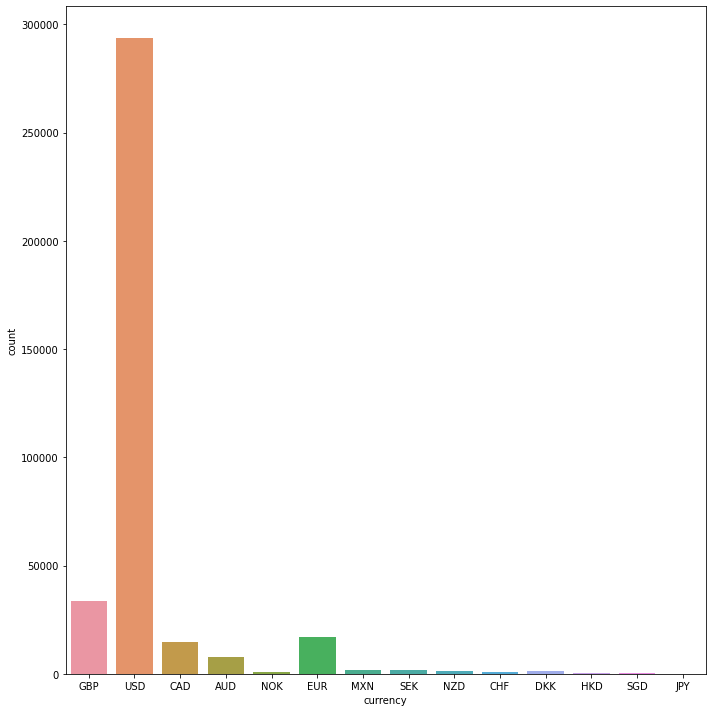

In [26]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

In [27]:
data['currency'].value_counts()

USD    293624
GBP     33853
EUR     17076
CAD     14830
AUD      7880
SEK      1768
MXN      1645
NZD      1464
DKK      1113
CHF       754
NOK       714
HKD       583
SGD       527
JPY        31
Name: currency, dtype: int64

In [28]:
data_USD = data['currency']=='USD'
print(f'USDの割合 : {data_USD.sum() / data.shape[0]}')

USDの割合 : 0.7812016112296535


In [29]:
data_GBP = data['currency']=='GBP'
data_EUR = data['currency']=='EUR'
data_CAD = data['currency']=='CAD'
data_AUD = data['currency']=='AUD'
print(f'USD, GBP, EUR, CAD, AUDが占める割合 : {(data_USD.sum() + data_GBP.sum() + data_EUR.sum() + data_CAD.sum() + data_AUD.sum()) / data.shape[0]}')

USD, GBP, EUR, CAD, AUDが占める割合 : 0.9771219224076921


currencyの分布からクラウドファンディングで使用される通貨の78%はUSDであることがわかる．<br>
またUSD, GBP, EUR, CAD, AUDで全体の97.71%を占めている為，その他の通貨に関してはcur_otherでまとめて扱うものとする．

In [30]:
# USD, GBP, EUR, CAD, AUD以外をcur_otherに書き換える
data = data.replace({'NOK' : 'cur_other', 'MXN' : 'cur_other', 'SEK' : 'cur_other', 'NZD' : 'cur_other', 'CHF' : 'cur_other', 'DKK' : 'cur_other', 'HKD' : 'cur_other', 'SGD' : 'cur_other', 'JPY' : 'cur_other'})
data['currency'].unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'cur_other', 'EUR'], dtype=object)

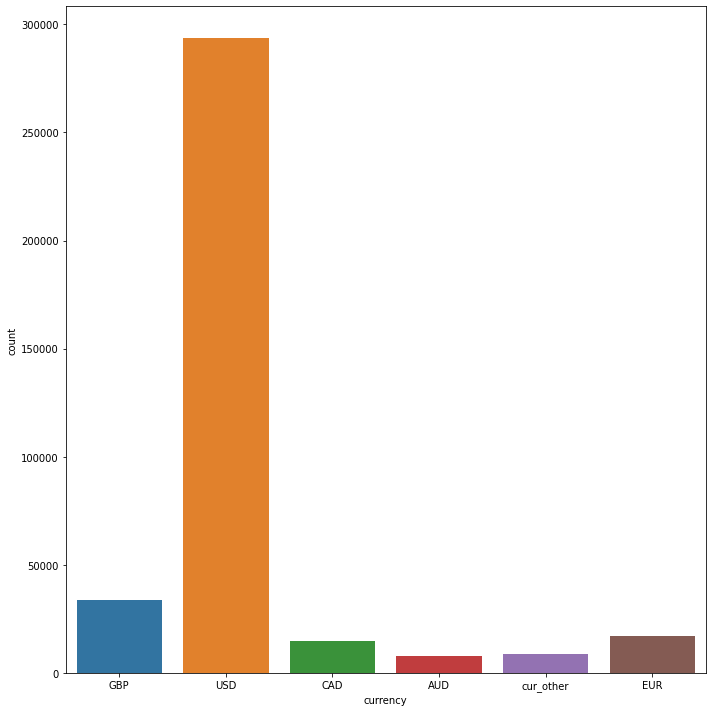

In [31]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

### country

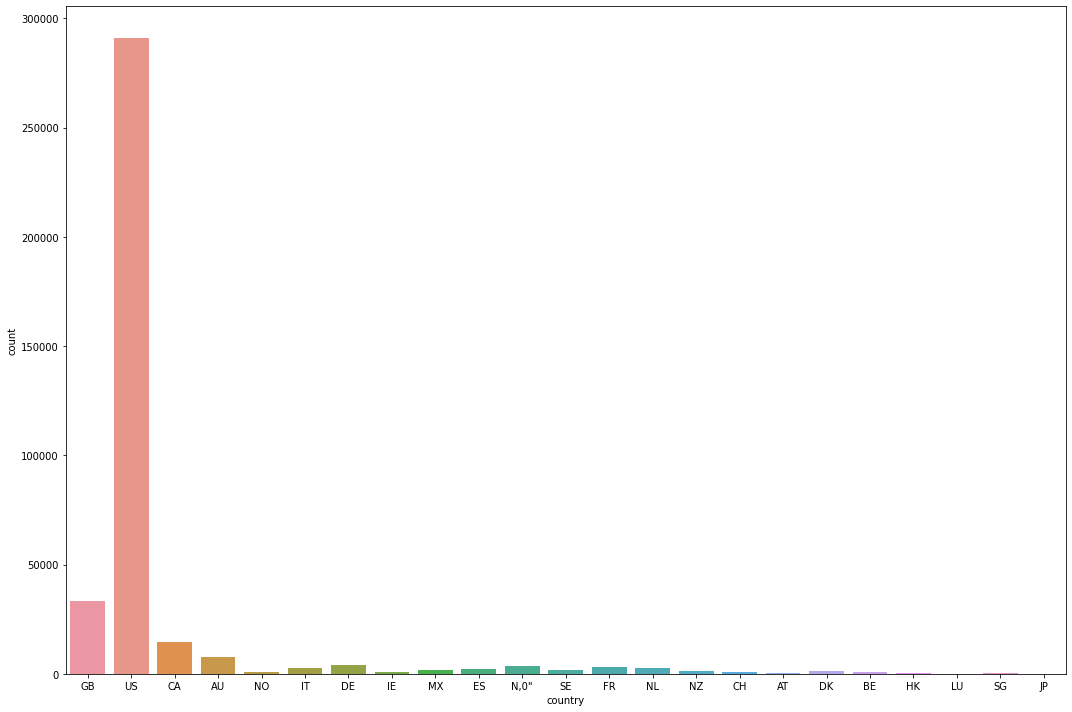

In [32]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()

In [33]:
data['country'].value_counts()

US      290887
GB       33393
CA       14624
AU        7769
DE        4096
N,0"      3796
FR        2887
NL        2833
IT        2802
ES        2224
SE        1737
MX        1645
NZ        1436
DK        1097
IE         800
CH         747
NO         700
BE         605
HK         583
AT         582
SG         527
LU          61
JP          31
Name: country, dtype: int64

In [34]:
data_US = data['country']=='US'
print(f'USの割合 : {data_US.sum() / data.shape[0]}')

USの割合 : 0.7739196832880153


In [35]:
data_GB = data['country']=='GB'
data_CA = data['country']=='CA'
data_AU = data['country']=='AU'
print(f'US + GB + CA + AUの割合 : {(data_US.sum() + data_GB.sum() + data_CA.sum() + data_AU.sum()) / data.shape[0]}')

US + GB + CA + AUの割合 : 0.9223411784112254


USでの募集が全体の77.39%を占めている．<br>
この変数はcurrencyと同様に，US，GB，CA，AUで全体の92.23%を占めているので，その他の国についてはcou_otherでまとめて扱うものとする．

In [36]:
# US, GB, CA, AU以外をcou_otherに書き換える
data = data.replace({'NO' : 'cou_other', 'IT' : 'cou_other', 'DE' : 'cou_other', 'IE' : 'cou_other', 'MX' : 'cou_other', 'ES' : 'cou_other', 'N,0"' : 'cou_other', 'SE' : 'cou_other', 'FR' : 'cou_other', 'NL' : 'cou_other', 'NZ' : 'cou_other', 'CH' : 'cou_other', 'AT' : 'cou_other', 'DK' : 'cou_other', 'BE' : 'cou_other', 'HK' : 'cou_other', 'LU' : 'cou_other', 'SG' : 'cou_other', 'JP' : 'cou_other'})
data['country'].unique()

array(['GB', 'US', 'CA', 'AU', 'cou_other'], dtype=object)

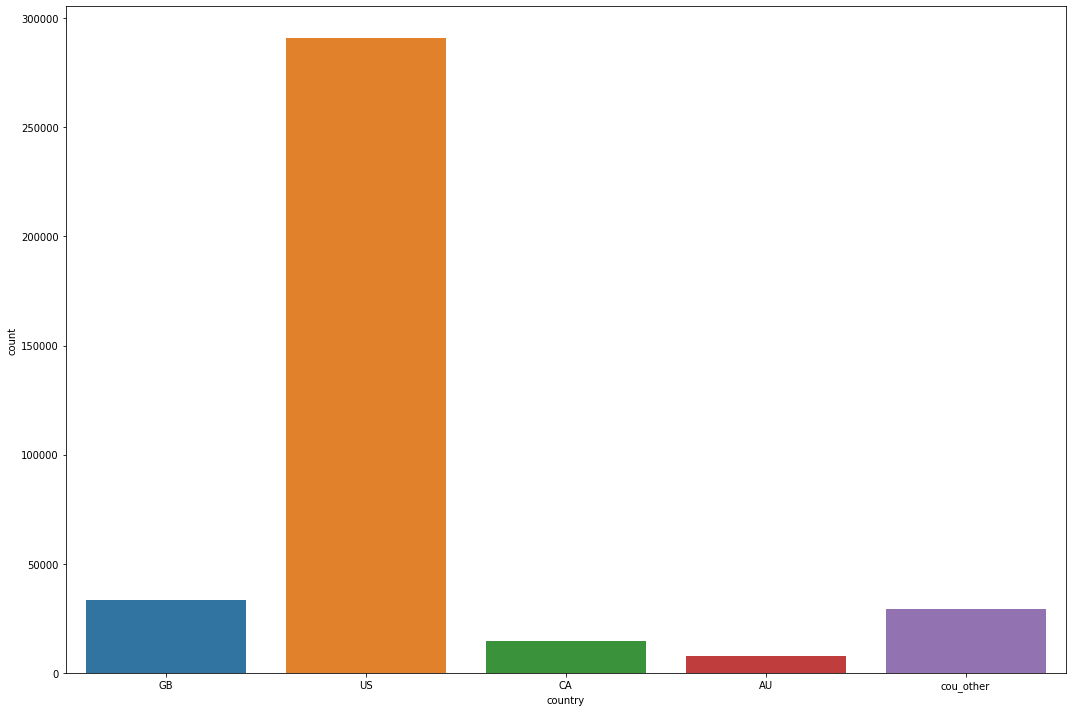

In [37]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()

### launched & deadline

launchedとdeadlineのデータからは
- クラウドファンディングを募集していた時期
- クラウドファンディングの募集期間

の情報が得られる．<br>
クラウドファンディングを行う季節の情報はlaunchedとdeadlineの月のデータから得られる．<br>
募集期間に関してはdeadlineとlaunchedの差の日数をとることで得られる．

In [38]:
# deadlineをstr型からdatetime型に変更
data['deadline'] = pd.to_datetime(data['deadline'])
# deadlineの一つ目のデータの月を抽出
print(data['deadline'][0].month)

10


In [39]:
# launchedについてもdatetime型に変更
data['launched'] = pd.to_datetime(data['launched'])

In [40]:
# 募集していた期間を新たな変数time_periodとしてdataに加える
data['time_period'] = data['deadline'] - data['launched']
data['time_period_days'] = data['time_period'].dt.days
data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
0,Other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58 days 11:47:32,58
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59 days 19:16:03,59
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44 days 23:39:10,44
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29 days 20:35:49,29
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55 days 15:24:57,55


### time_period_days

time_period_daysは何日間クラウドファンディングの募集を行っていたかを表す新しい変数である．<br>
この変数の各々の数値について出現頻度のグラフを以下に示す．

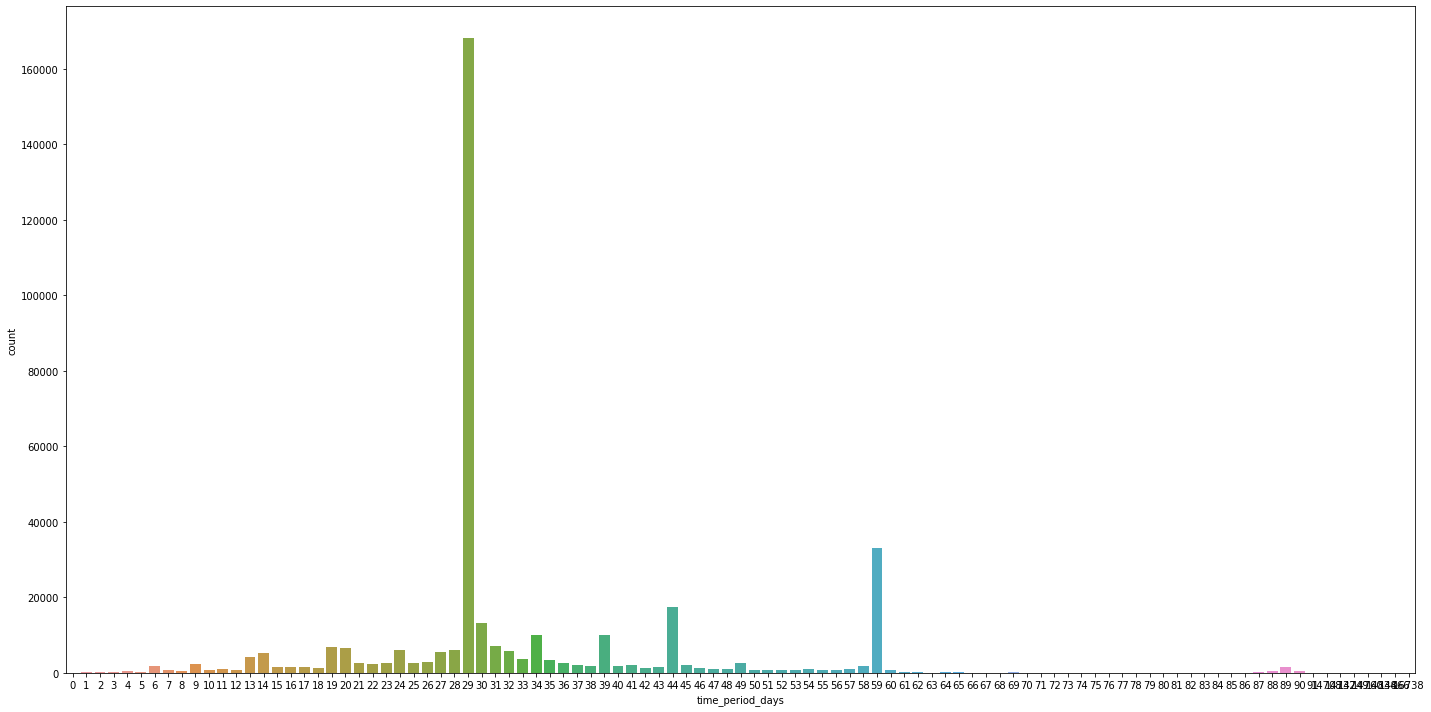

In [41]:
plt.figure(figsize=(20, 10))
sns.countplot(x='time_period_days', data=data)
plt.tight_layout()

In [42]:
data['time_period_days'].value_counts()

29       168112
59        33018
44        17552
30        13197
34        10014
          ...  
14732         1
14760         1
16738         1
14866         1
14834         1
Name: time_period_days, Length: 99, dtype: int64

In [43]:
data_29days = data['time_period_days']==29
print(f'29日間募集を行っていた件数 : {data_29days.sum() / data.shape[0]}')

29日間募集を行っていた件数 : 0.44727054078358547


In [44]:
data_time_period_days = data['time_period_days'].value_counts()
data_time_period_days = pd.DataFrame(data_time_period_days)

print('time_period_daysの出現回数が50回以下のカテゴリ数')
print(sum(data_time_period_days['time_period_days'] <= 50))
print('time_period_daysの出現回数が50回以下のデータ数')
print(data_time_period_days[data_time_period_days['time_period_days'] <= 50].sum()[0] / data.shape[0])

time_period_daysの出現回数が50回以下のカテゴリ数
10
time_period_daysの出現回数が50回以下のデータ数
0.00030330280794546935


In [45]:
data['time_period_days'].max()

16738

In [46]:
data[data['time_period_days']==16738]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
316658,Publishing,Publishing,cur_other,2015-10-31,1900.0,1970-01-01 01:00:00,failed,cou_other,1905.97,16738 days 23:00:00,16738


この分布から29日間募集しているものが多く全体の44.72%を占めていることがわかる．<br>
また最大で16738日間(約45年間)行っているものもあることがわかった．<br>
しかしこのデータはlaunchedが1970年1月1日になっており，以下のkickstarterのHPに記載されているkickstarterの誕生(2009年4月28日)以前から存在することになるので，外れ値であると考えられる．<br>
https://www.kickstarter.com/about?ref=global-footer<br>
ここでlaunchedのデータについて2009年4月28日以前に開始されているデータは以下の12件である．

In [47]:
data[data['launched'] <= datetime.datetime(2009, 4, 28)]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
2822,Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,failed,US,5000.00,14866 days 23:00:00,14866
47802,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,failed,US,15000.00,14834 days 23:00:00,14834
74841,Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,failed,US,700.00,14749 days 23:00:00,14749
93894,Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,failed,US,4000.00,14760 days 23:00:00,14760
121749,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,failed,US,1900.00,28 days 09:49:21,28
137539,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,successful,US,20.00,8 days 02:07:57,8
168009,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,failed,US,1000.00,39 days 02:57:12,39
246089,Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,failed,US,10000.00,14732 days 23:00:00,14732
271793,Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,failed,US,500.00,14708 days 23:00:00,14708
316658,Publishing,Publishing,cur_other,2015-10-31,1900.0,1970-01-01 01:00:00,failed,cou_other,1905.97,16738 days 23:00:00,16738


この12件のうちlaunchedが1970-01-01でない5件については2009年4月28日以前から開始されているが，募集期間の長さから考えて異常と言える数値ではないのでこの値を使用する．<br>
一方，launchedが1970-01-01となった7件については，time_period_daysが29日になるようにlaunchedを変更する．<br>
29日としたのは募集期間が29日間のデータが最も多かったからである．

In [48]:
data['launched'][2822] =  datetime.datetime(2010, 8, 17)
data.loc[2822]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                   Film & Video
main_category              Film & Video
currency                            USD
deadline            2010-09-15 00:00:00
goal                               5000
launched            2010-08-17 00:00:00
state                            failed
country                              US
usd_goal_real                      5000
time_period         14866 days 23:00:00
time_period_days                  14866
Name: 2822, dtype: object

In [49]:
data['launched'][47802] =  datetime.datetime(2010, 7, 16)
data.loc[47802]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                            Art
main_category                       Art
currency                            USD
deadline            2010-08-14 00:00:00
goal                              15000
launched            2010-07-16 00:00:00
state                            failed
country                              US
usd_goal_real                     15000
time_period         14834 days 23:00:00
time_period_days                  14834
Name: 47802, dtype: object

In [50]:
data['launched'][74841] =  datetime.datetime(2010, 4, 22)
data.loc[74841]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                   Film & Video
main_category              Film & Video
currency                            USD
deadline            2010-05-21 00:00:00
goal                                700
launched            2010-04-22 00:00:00
state                            failed
country                              US
usd_goal_real                       700
time_period         14749 days 23:00:00
time_period_days                  14749
Name: 74841, dtype: object

In [51]:
data['launched'][93894] =  datetime.datetime(2010, 5, 3)
data.loc[93894]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                        Theater
main_category                   Theater
currency                            USD
deadline            2010-06-01 00:00:00
goal                               4000
launched            2010-05-03 00:00:00
state                            failed
country                              US
usd_goal_real                      4000
time_period         14760 days 23:00:00
time_period_days                  14760
Name: 93894, dtype: object

In [52]:
data['launched'][246089] =  datetime.datetime(2010, 4, 5)
data.loc[246089]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                          Music
main_category                     Music
currency                            USD
deadline            2010-05-04 00:00:00
goal                              10000
launched            2010-04-05 00:00:00
state                            failed
country                              US
usd_goal_real                     10000
time_period         14732 days 23:00:00
time_period_days                  14732
Name: 246089, dtype: object

In [53]:
data['launched'][271793] =  datetime.datetime(2010, 3, 12)
data.loc[271793]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                         Design
main_category                    Design
currency                            USD
deadline            2010-04-10 00:00:00
goal                                500
launched            2010-03-12 00:00:00
state                            failed
country                              US
usd_goal_real                       500
time_period         14708 days 23:00:00
time_period_days                  14708
Name: 271793, dtype: object

In [54]:
data['launched'][316658] =  datetime.datetime(2015, 10, 2)
data.loc[316658]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


category                     Publishing
main_category                Publishing
currency                      cur_other
deadline            2015-10-31 00:00:00
goal                               1900
launched            2015-10-02 00:00:00
state                            failed
country                       cou_other
usd_goal_real                   1905.97
time_period         16738 days 23:00:00
time_period_days                  16738
Name: 316658, dtype: object

In [55]:
# 再度確認
data[data['launched'] <= datetime.datetime(2009, 4, 28)]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
121749,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,failed,US,1900.0,28 days 09:49:21,28
137539,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,successful,US,20.0,8 days 02:07:57,8
168009,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,failed,US,1000.0,39 days 02:57:12,39
319623,Shorts,Film & Video,USD,2009-07-20,80000.0,2009-04-23 00:07:53,failed,US,80000.0,87 days 23:52:07,87
322995,Software,Technology,USD,2009-07-14,99.0,2009-04-25 17:36:21,successful,US,99.0,79 days 06:23:39,79


In [56]:
# 再度，募集していた期間を新たな変数time_periodとしてdataに加える
data['time_period'] = data['deadline'] - data['launched']
data['time_period_days'] = data['time_period'].dt.days

In [57]:
data['time_period_days'].value_counts()

29    168119
59     33018
44     17552
30     13197
34     10014
       ...  
82        54
76        52
73        46
78        39
91        22
Name: time_period_days, Length: 92, dtype: int64

launchedの異常値はこれで取り除くことができたが，deadlineについても異常値の除去を行う必要がある．<br>
deadlineの異常値として考えられるものはlaunchedがdeadlineよりも後に来ている，つまり変数time_periodが負の値になっている状況である．<br>
まず異常値の候補である，変数time_period_daysが0以下のデータを抽出する．

In [58]:
data[data['time_period_days']<=0]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
888,Video Games,Games,GBP,2015-06-11,5000.0,2015-06-10 19:03:39,failed,GB,7743.29,0 days 04:56:21,0
926,Other,Music,USD,2016-02-19,500.0,2016-02-18 04:29:22,failed,US,500.00,0 days 19:30:38,0
10361,Software,Technology,USD,2017-03-05,10000000.0,2017-03-04 01:25:03,failed,US,10000000.00,0 days 22:34:57,0
12390,Film & Video,Film & Video,GBP,2016-06-15,130.0,2016-06-14 02:24:00,successful,GB,185.73,0 days 21:36:00,0
20200,Art,Art,USD,2016-04-02,8888.0,2016-04-01 08:38:27,failed,US,8888.00,0 days 15:21:33,0
...,...,...,...,...,...,...,...,...,...,...,...
365859,Other,Publishing,GBP,2014-03-02,5.0,2014-03-01 13:20:34,successful,GB,8.39,0 days 10:39:26,0
368167,Other,Art,cur_other,2016-08-02,5.0,2016-08-01 21:44:53,successful,cou_other,3.73,0 days 02:15:07,0
369608,Tabletop Games,Games,EUR,2017-08-06,69.0,2017-08-05 18:05:40,failed,cou_other,81.18,0 days 05:54:20,0
372775,Publishing,Publishing,USD,2016-02-28,250.0,2016-02-27 04:40:59,successful,US,250.00,0 days 19:19:01,0


募集期間が1日以下のデータは102件あることがわかる．<br>
この中でtime_periodが負の値になっているものを見つけることを考える．<br>
ここでtime_periodはdeadline - launchedを計算しているので，time_periodの絶対値とtime_periodが一致しないデータは異常であると考えられるので，全データに対してtime_periodとtime_periodの絶対値の比較を行う．<br>

In [59]:
data[data['time_period']!=abs(data['deadline'] - data['launched'])]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days


上記のようにtime_periodとtime_periodの絶対値が一致しないデータは存在しないため，deadlineについては異常値は存在しないと考えられる．

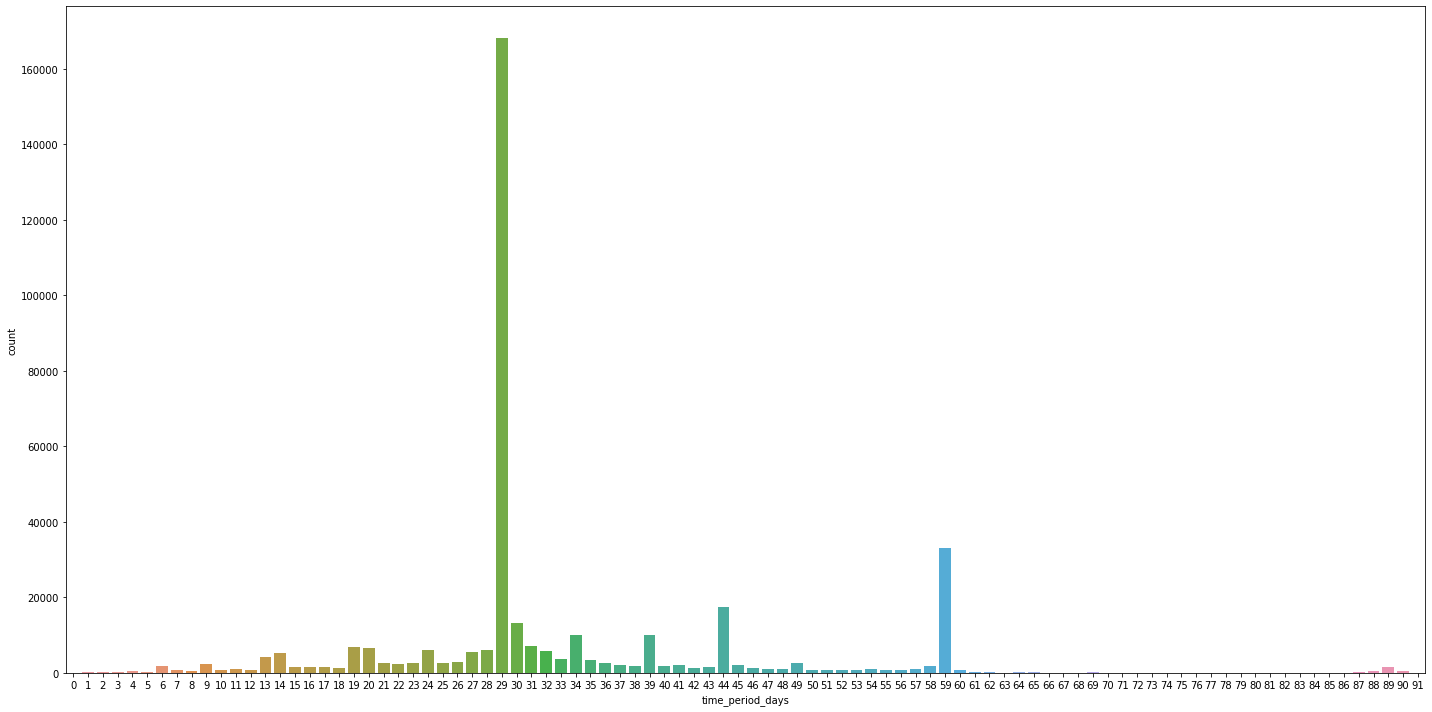

In [60]:
# 異常値変更後の頻度分布
plt.figure(figsize=(20, 10))
sns.countplot(x='time_period_days', data=data)
plt.tight_layout()

In [61]:
# 異常値変更後の最大値
data['time_period_days'].max()

91

変数time_periodは日数をtime_period_daysとして取り出したので削除する．

In [62]:
# dataから説明変数として用いない変数を消去
data.drop(['time_period'], axis=1, inplace=True)

data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days
0,Other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55


### launched_month

ここではlaunchedの月の情報を抽出する．<br>
月の情報はlaunchedになった時期の情報を持っており，季節による違いを見るために使用する．

In [63]:
data['launched_month'] = data['launched'].dt.month
data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days,launched_month
0,Other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58,8
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59,9
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44,1
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29,3
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55,7


### goal & usd_goal_real

goalとusd_goal_realはどちらも集めたい金額を表している．<br>
goalはUSDやGBPなどの異なる通貨が同一の値として表示されており，異なる通貨は直接比較することができないので，分類にそのまま用いることは難しい．<br>
一方usd_goal_realは全てUSDに変換された値なので，値同士を直接比較することができる．<br>
よってここからはgoalではなくusd_goal_realについて見ていく．

In [64]:
print(len(set(data['usd_goal_real'])))
print(sorted(set(data['usd_goal_real'])))

49884
[0.01, 0.15, 0.49, 0.5, 0.55, 0.58, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.81, 0.83, 0.86, 0.88, 0.89, 0.91, 0.93, 0.97, 1.0, 1.04, 1.06, 1.08, 1.09, 1.1, 1.11, 1.14, 1.18, 1.22, 1.23, 1.28, 1.29, 1.3, 1.32, 1.33, 1.34, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.57, 1.58, 1.62, 1.63, 1.66, 1.67, 1.68, 1.7, 1.83, 1.85, 2.0, 2.23, 2.24, 2.26, 2.4, 3.0, 3.03, 3.12, 3.32, 3.34, 3.36, 3.39, 3.6, 3.66, 3.69, 3.72, 3.73, 3.76, 3.79, 3.92, 3.95, 4.0, 4.06, 4.25, 4.36, 4.38, 4.47, 4.55, 4.58, 4.64, 4.67, 4.71, 4.87, 4.97, 5.0, 5.06, 5.09, 5.32, 5.43, 5.57, 5.58, 5.59, 5.8, 5.97, 6.0, 6.05, 6.21, 6.39, 6.52, 6.56, 6.81, 6.98, 7.0, 7.09, 7.17, 7.32, 7.38, 7.39, 7.4, 7.44, 7.49, 7.51, 7.55, 7.61, 7.66, 7.72, 7.74, 7.76, 7.79, 7.81, 7.85, 7.88, 7.89, 7.91, 7.92, 7.97, 7.99, 8.0, 8.03, 8.24, 8.27, 8.29, 8.35, 8.37, 8.39, 8.4, 8.43, 8.52, 8.54, 8.56, 8.62, 8.63, 8.67, 8.79, 8.81, 8.93, 9.0, 9.04, 9.05, 9.06, 9.11, 9.13, 9.15, 9.16, 9.17, 9.21, 9.28

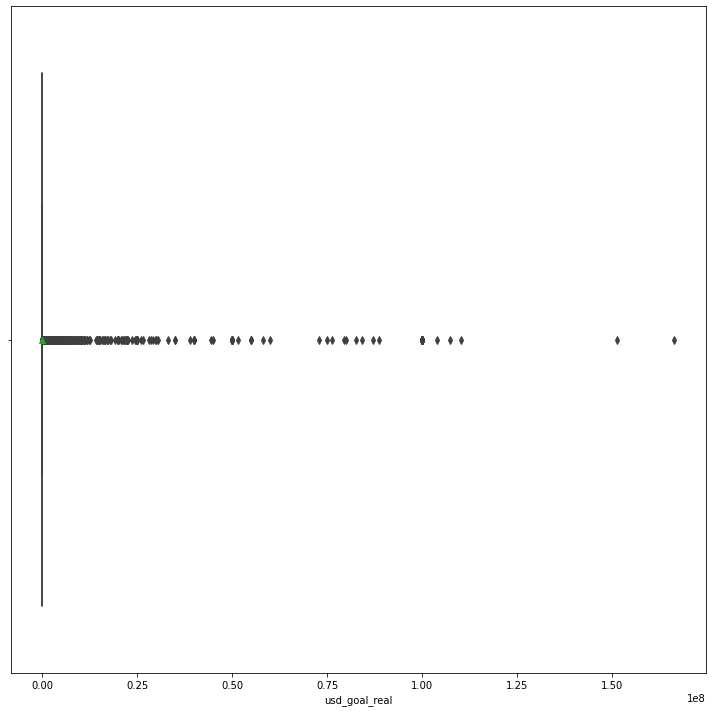

In [65]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='usd_goal_real', data=data, showmeans=True)
plt.tight_layout()
plt.show()

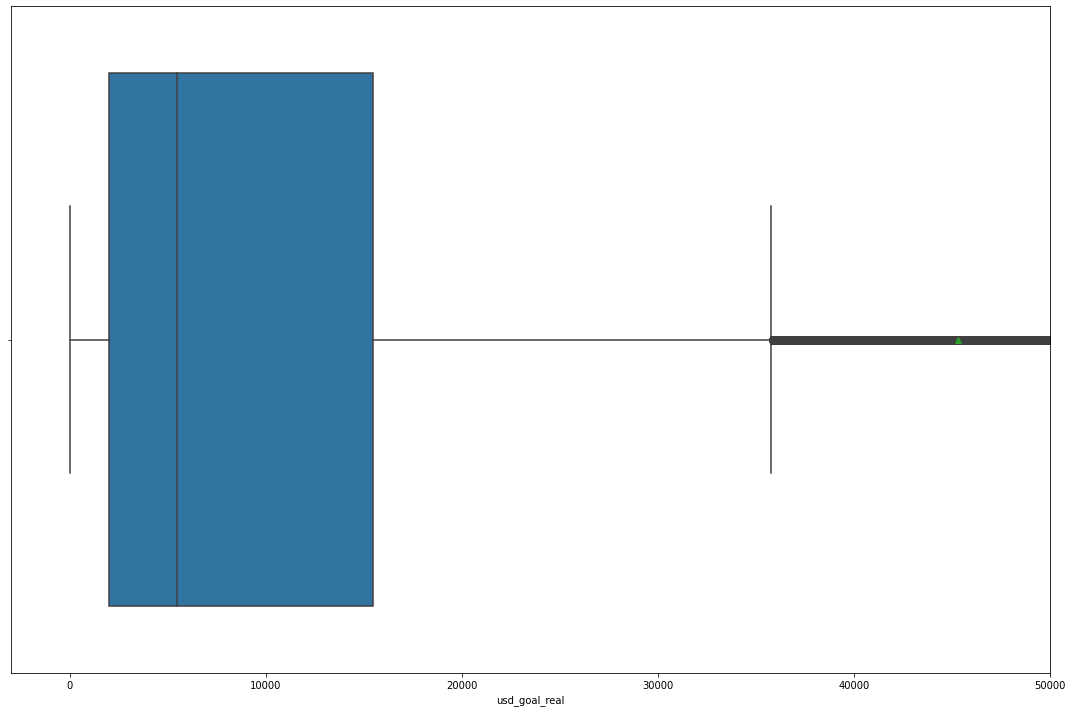

In [66]:
# 上図の0~5*10^4の範囲を拡大したもの
plt.figure(figsize=(15, 10))
sns.boxplot(x='usd_goal_real', data=data, showmeans=True)
plt.xlim(-3*10**3, 5*10**4)
plt.tight_layout()

In [67]:
data_usd_goal_real = data['usd_goal_real']

print(f'最小値 : {data_usd_goal_real.min()}')
print(f'最大値 : {data_usd_goal_real.max()}')
print(f'平均 : {data_usd_goal_real.mean()}')
print(f'第三四分位数 : {data_usd_goal_real.quantile(0.75)}')

最小値 : 0.01
最大値 : 166361390.71
平均 : 45327.20217002516
第三四分位数 : 15500.0


usd_goal_realは約5万種で構成されており，
- 最小値 : $0.01$USD
- 最大値 : $1.66\times 10^8$USD
- 平均値 : $4.53\times 10^4$USD

である．<br>
また箱ヒゲ図の分布からusd_goal_realが低い募集が非常に多く，75%の募集が15500USD以下の募集であることがわかる．<br>
以上より
- usd_goal_realには負の値は含まれていない
- usd_goal_realは非常に広範囲に分布しているが，異常と呼べる値は含まれていない

ことがわかる．<br>
よってこのusd_goal_realについてはこのまま使用する．

# 目的変数と説明変数の関係性

ここでは目的変数と説明変数の関係性を確認する．

## 変数の数値変換

変数stateと相関がある変数を見つけることが目的なので，カテゴリ変数を数値に変換する必要がある．<br>
まず全てのカテゴリ変数をlabel encodingを行って数値に変換する．

### 目的変数の変換

In [68]:
# failedを0，successfulを1に変換
data = data.replace({'failed' : 0, 'successful' : 1})
data.head(10)

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days,launched_month
0,Other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0,GB,1533.95,58,8
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,0,US,30000.00,59,9
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,0,US,45000.00,44,1
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,0,US,5000.00,29,3
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,0,US,19500.00,55,7
5,Other,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,1,US,50000.00,34,2
6,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1,US,1000.00,19,12
7,Other,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,0,US,25000.00,44,2
8,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,0,US,125000.00,34,4
9,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,0,US,65000.00,29,7


### 説明変数の変換

In [69]:
data_exp = data.copy(deep=True)
data_exp

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days,launched_month
0,Other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0,GB,1533.95,58,8
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,0,US,30000.00,59,9
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,0,US,45000.00,44,1
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,0,US,5000.00,29,3
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,0,US,19500.00,55,7
...,...,...,...,...,...,...,...,...,...,...,...
375857,Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,0,US,50000.00,29,9
375858,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,0,US,1500.00,26,6
375859,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,0,US,15000.00,45,7
375860,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,0,US,15000.00,30,1


In [70]:
# categoryの変換
le = LabelEncoder()
encoded = le.fit(data_exp['category'])
data_exp['category'] = encoded.transform(data_exp['category'])
data_exp.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days,launched_month
0,22,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0,GB,1533.95,58,8
1,20,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,0,US,30000.00,59,9
2,20,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,0,US,45000.00,44,1
3,19,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,0,US,5000.00,29,3
4,12,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,0,US,19500.00,55,7


## 目的変数と説明変数の関係性

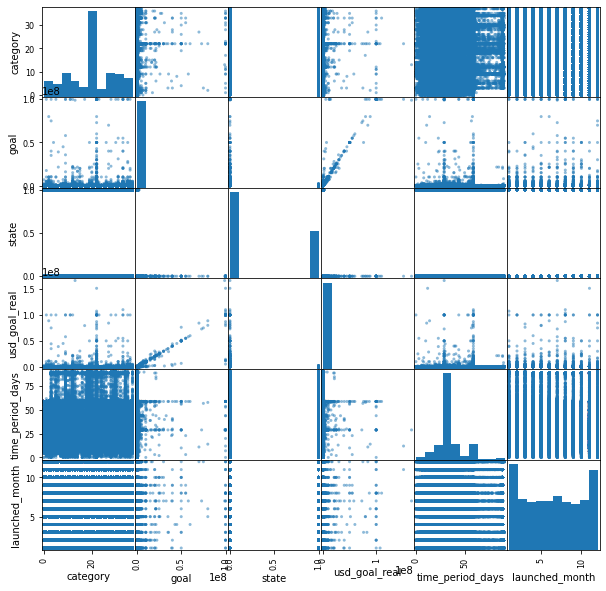

In [71]:
pd.plotting.scatter_matrix(data_exp, figsize=(10, 10))
plt.show()

<AxesSubplot:>

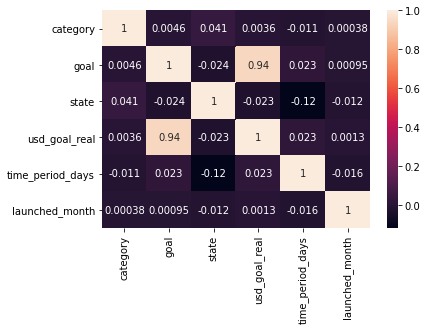

In [72]:
sns.heatmap(data_exp.corr(), annot=True)

# データの前処理

ここではデータの前処理として
- 不要な変数の削除
- カテゴリ変数のone-hot encoding

を行う．

In [79]:
data_exp2 = data.copy(deep=True)

In [80]:
data_dummy = pd.get_dummies(data_exp2)
data_dummy.head()

,deadline,goal,launched,state,usd_goal_real,time_period_days,launched_month,category_Accessories,category_Apparel,category_Apps,...,currency_CAD,currency_EUR,currency_GBP,currency_USD,currency_cur_other,country_AU,country_CA,country_GB,country_US,country_cou_other
0,2015-10-09,1000.0,2015-08-11 12:12:28,0,1533.95,58,8,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2017-11-01,30000.0,2017-09-02 04:43:57,0,30000.00,59,9,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,2013-02-26,45000.0,2013-01-12 00:20:50,0,45000.00,44,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,2012-04-16,5000.0,2012-03-17 03:24:11,0,5000.00,29,3,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,2015-08-29,19500.0,2015-07-04 08:35:03,0,19500.00,55,7,0,0,0,...,0,0,0,1,0,0,0,0,1,0


main_categoryは15種類存在し，
- Music, Theater, Danceはfailedよりもsuccessfulの方が多い
- Food, Technologyは他のカテゴリよりも成功率が低い
- Design, Gamesは他のカテゴリよりもcanceledの割合が高い

ということがわかる．